# Exercise 1: Spark and MapReduce

#### Task 1.1   





**What is the difference between a set and a bag?**

A set is an unordered collection where all elements are unique, while a bag is similar to a set (a bag also called multiset) but it allows duplicate elements.




**Consider a relational-algebra operation 𝑅(𝐴, 𝐵) ⋈𝐵<𝐶 𝑆(𝐶, 𝐷), where 𝑅 and 𝑆 are sets. What does this operation produce (refer to section 2.3.3 in the book)?**

This operation produces a set of tuples from R and S where the B value from R is less than the C value from S. So basically, for every tuple (A, B) in R and (C, D) in S, and if B < C, it adds the tuple (A, B, C, D) to the result

**Give a MapReduce implementation of this operation. Describe the implementation is a similar way as corresponding descriptions in sections 2.3.4 – 2.3.10 in the book. The task is also given as exercise 2.3.5 in the book.**

At the start of the MapReduce, each tuple is taken individually. In the Map phase, for each tuple (A, B) in R, the mapper creates key value pairs for every key greater than B. At the same time, for each tuple (C, D) in S, it creates key-value pairs using C as the key. After that we have the shuffle and sort phase, where key-value pairs are grouped by key. Later in the Reduce phase, every selected tuple from R is pared with the corresponding tuples from S, producing the  tuple (A, B, C, D) where B < C.


#### Task 1.2    





In [3]:
from random import random
from operator import add
import pyspark
sc = pyspark.SparkContext("local", "CalculatePi")
partitions = 10
n = 100000 * partitions
#function which evaluates if the random x,y point is inside the unit circle
def f(_):
    x = random() * 2 - 1
    y = random() * 2 - 1
    return 1 if x ** 2 + y ** 2 < 1 else 0
#parallelize = make a range of keys and partition keys to x partitions
#assing a value to each key with .map(f)
#and finally reduce the values by summation
rdd = sc.parallelize(range(1, n + 1), partitions)
count = rdd.map(f).reduce(add)
print("Pi is roughly %f" % (4.0 * count / n))
sc.stop()

Pi is roughly 3.148640


**What does the code do?**


It approximates the value of Pi. it is done by counting how many randomly generated points fall inside the circle and then divides inside count by total points and multiplies by 4.

**What does sc.parallelize do?**


It converts a Python collection into a Resilient Distributed Dataset, which is then used for parallel processing as required by MapReduce.

**What are the key-value pairs produced by the map function?**


In this case, map function doesn’t produce key-value pairs but instead returns  1 or 0 for each point, showing whether the point is inside or outside the circle.

**Compare the estimate of Pi when you use less/more data**


The fewer data points are used, the less accurate the Pi estimation will be. At the same time, the more data points used, the more accurate the estimate becomes.

#### Task 1.3    





In [4]:
import pyspark
sc = pyspark.SparkContext("local", "words")
lines = sc.textFile("pg1513.txt")
words = lines.map(lambda line:
line.replace(".","").replace(",","").replace("?","").replace("\t","").replace(":","")
                  .replace("!","").replace("-","").lower()).flatMap(lambda line: line.split(" "))
keyvalue = words.map(lambda word: (word, 1))
counts = keyvalue.reduceByKey(lambda a, b: a + b)
#retrieve at most 200 key value pairs from the rdd (it’s not wise to try to get everything)
for x in counts.take(10):
    print(x)
sc.stop()

('the', 874)
('project', 84)
('gutenberg', 27)
('ebook', 12)
('of', 518)
('romeo', 298)
('and', 802)
('juliet', 180)
('', 1691)
('this', 263)


**What does the mapper do and what is it’s output?**

The mapper cleans each line by removing punctuation and converting to lowercase, then splits the line into words. It outputs (word, 1) for each word, that shows an occurrence of that word.

**What does the reducer do?**


It sums up all the 1s associated with each word key and outputs the final count of how many times each word appears in the text.

#### Task 1.4     





**Write a simple MapReduce program which reads two text files (you can download test data from https://www.gutenberg.org/) and sorts the words according to their number of occurrences. Clean input data from trash like '%&. Remove also empty words and numbers.**

**Select ten most frequent words from each text and plot a bargraph that illustrates the number of occurrences of these 10 words in each document.**

**Take the 10 most frequent words in each text, select unique words, and draw a graph which illustrates the occurrence of these words in both texts. This can be either a grouped bar graph or a scatterplot with the occurrences in each text on x- and y-axes**

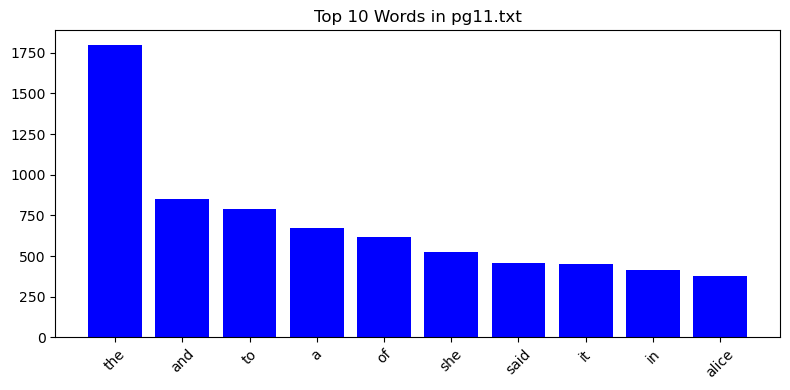

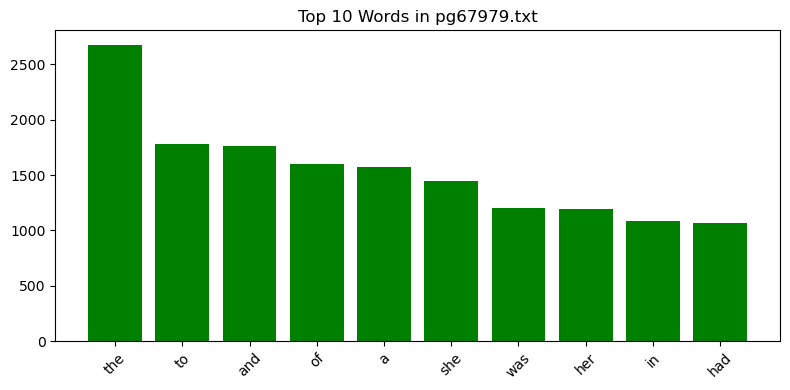

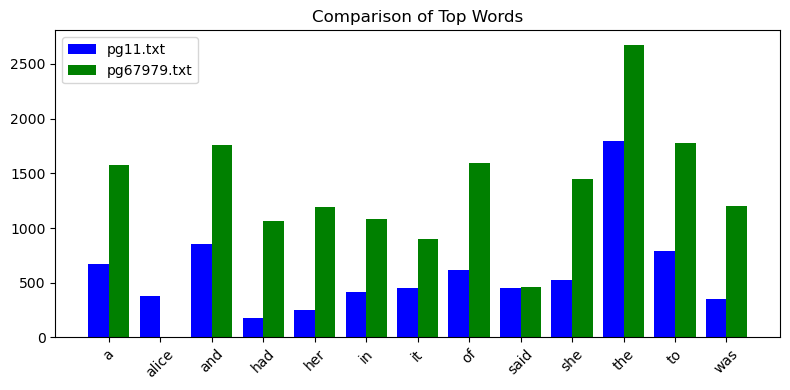

In [5]:
import pyspark
from pyspark import SparkContext
import matplotlib.pyplot as plt
import numpy as np
import re

sc = SparkContext("local", "Task1_4")

text1 = sc.textFile("pg11.txt")
text2 = sc.textFile("pg67979.txt")

words1 = text1.map(lambda line: re.sub(r"[%&.,!?;:\-\t]+", "", line.lower())).flatMap(lambda line: line.split(" ")).filter(lambda w: w and not w.isnumeric())
words2 = text2.map(lambda line: re.sub(r"[%&.,!?;:\-\t]+", "", line.lower())).flatMap(lambda line: line.split(" ")).filter(lambda w: w and not w.isnumeric())

counts1 = words1.map(lambda w: (w, 1)).reduceByKey(lambda a, b: a + b)
counts2 = words2.map(lambda w: (w, 1)).reduceByKey(lambda a, b: a + b)

sorted1 = counts1.sortBy(lambda x: x[1], ascending=False)
sorted2 = counts2.sortBy(lambda x: x[1], ascending=False)

top10_1 = sorted1.take(10)
top10_2 = sorted2.take(10)

w1, c1 = zip(*top10_1)
w2, c2 = zip(*top10_2)

plt.figure(figsize=(8, 4))
plt.bar(w1, c1, color='blue')
plt.title("Top 10 Words in pg11.txt")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(w2, c2, color='green')
plt.title("Top 10 Words in pg67979.txt")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

unique_words = set([w for w, _ in top10_1] + [w for w, _ in top10_2])
dict1 = dict(counts1.collect())
dict2 = dict(counts2.collect())
combined_words = sorted(list(unique_words))
combined_freq1 = [dict1.get(w, 0) for w in combined_words]
combined_freq2 = [dict2.get(w, 0) for w in combined_words]

x = np.arange(len(combined_words))
width = 0.4

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, combined_freq1, width, color='blue', label='pg11.txt')
plt.bar(x + width/2, combined_freq2, width, color='green', label='pg67979.txt')
plt.xticks(x, combined_words, rotation=45)
plt.title("Comparison of Top Words")
plt.legend()
plt.tight_layout()
plt.show()

sc.stop()